# 9章 CNNによる画像認識

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm
import wandb
import yaml
from pythonlibs.torch_lib_wandb import *
print(README)

wandb version


In [2]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))
# 結果確認
print(n_output)

10


In [4]:
# ドロップアウトテスト用ダミーデータの作成
torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [5]:
# dropout関数の定義
dropout = nn.Dropout(0.5)
# 訓練フェーズでの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)
# 予測フェーズでの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [6]:
# Transformsの定義
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [7]:
# データ取得用関数 Dataset
data_root = './data'
train_set = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform)
# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, 
    batch_size = batch_size, shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,  
    batch_size = batch_size, shuffle = False) 

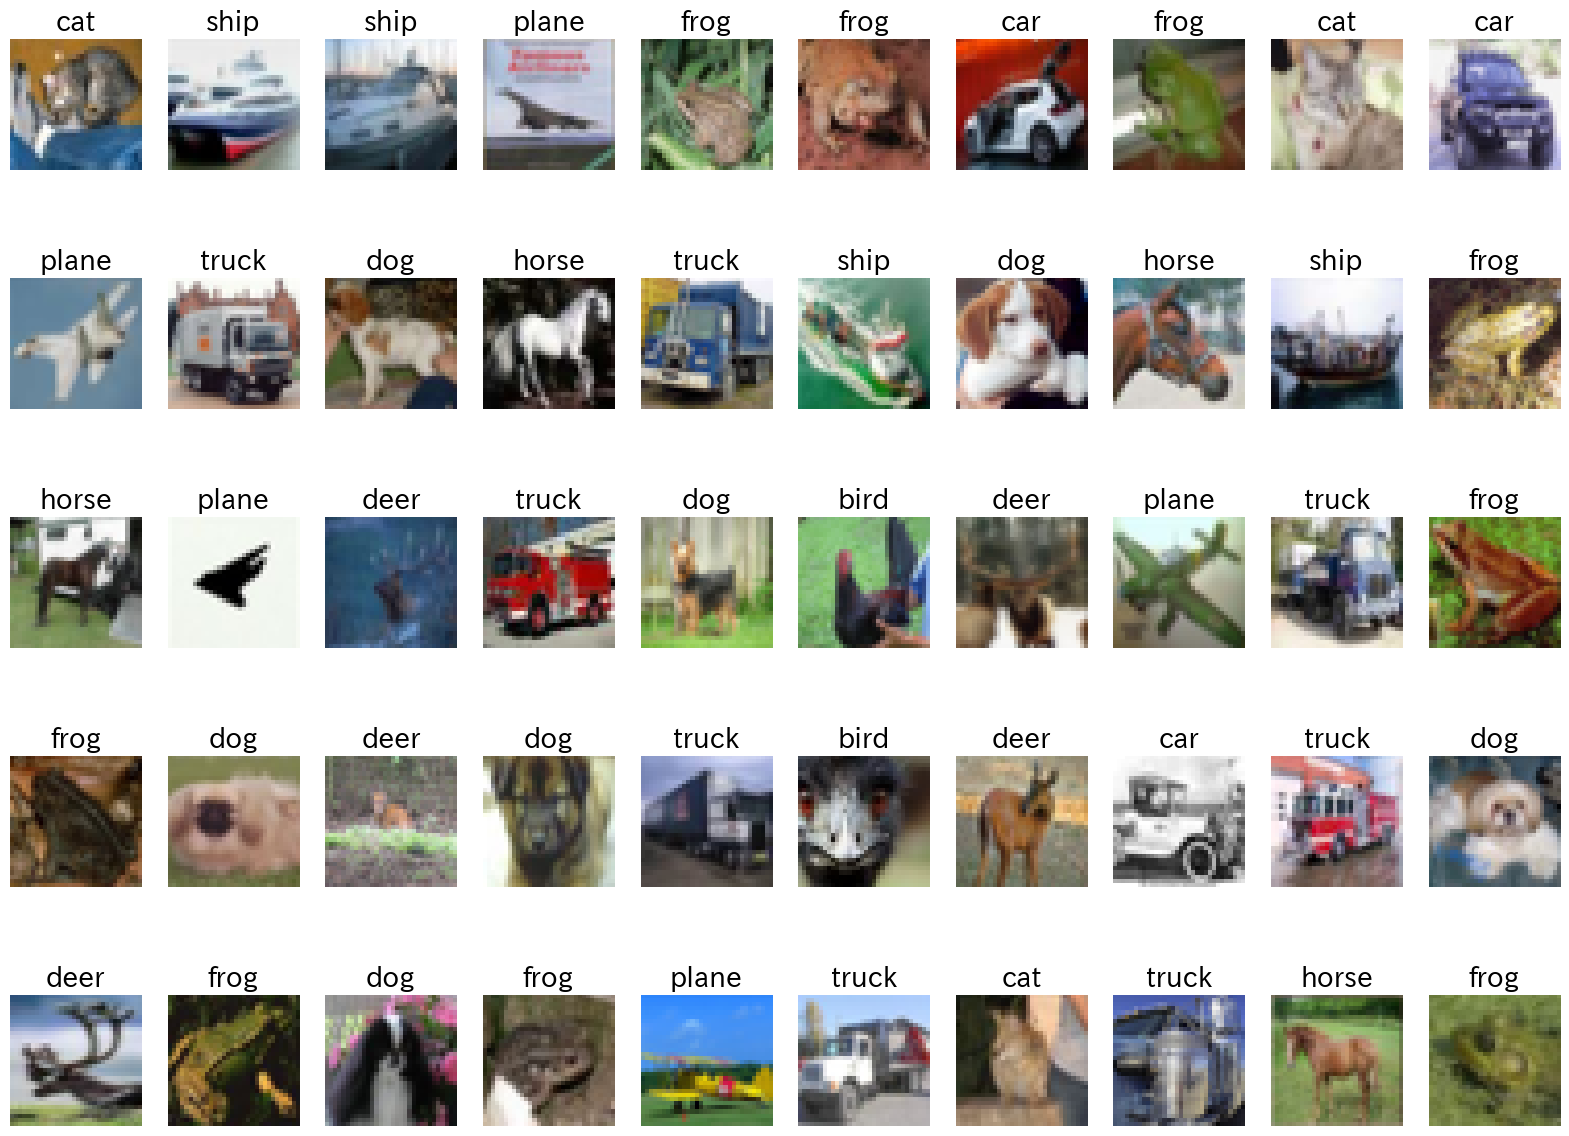

In [9]:
# 最初の50個の表示
show_images_labels(test_loader, classes, None, None)

In [10]:
class CNN_v1(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, 128)
    self.l2 = nn.Linear(128, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

In [11]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [12]:
# 予測クラスの定義
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [13]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [14]:
def main():
    wandb.init()
    # 損失関数のグラフ表示
    if wandb.config["Net"] == "CNN_v1":
        net = CNN_v1(n_output).to(device)
    elif wandb.config["Net"] == "CNN_v2":
        net = CNN_v2(n_output).to(device)
    elif wandb.config["Net"] == "CNN_v3":
        net = CNN_v3(n_output).to(device)
    elif wandb.config["Net"] == "CNN_v4":
        net = CNN_v4(n_output).to(device)

    criterion = nn.CrossEntropyLoss()
    #loss = eval_loss(test_loader, device, net, criterion)
    #g = make_dot(loss, params=dict(net.named_parameters()))
    #display(g)
    # 乱数の固定化
    torch_seed()
    # モデルインスタンス生成
    lr = 0.01
    criterion = nn.CrossEntropyLoss()
    num_epochs = 50
    history = np.zeros((0, 5))

    if wandb.config["optimizer"] == "SDG":
        # SGD
        optimizer = optim.SGD(net.parameters(), lr=lr)
        history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)
    elif wandb.config["optimizer"] == "SDG_momentum":
        # SGD momentum
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
        history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)
    elif wandb.config["optimizer"] == "Adam":
        # Adam
        optimizer = optim.Adam(net.parameters())
        history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

### 比較

In [15]:
#パラメータ読み込み
def yaml_read(yaml_file):
    with open(yaml_file) as f:
        cfg = yaml.safe_load(f)
    return cfg

In [16]:
def sweep():
  sweep_config = yaml_read("config_sweep_CNN_v.yaml")
  sweep_id = wandb.sweep(sweep_config, project="test_sweep_CNN_v")
  wandb.agent(sweep_id, main)

In [17]:
sweep()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: p74o324k
Sweep URL: https://wandb.ai/sota-moro/test_sweep_CNN_v/sweeps/p74o324k


wandb: Agent Starting Run: l3zm9wl2 with config:
wandb: 	Net: CNN_v1
wandb: 	optimizer: SDG
Run l3zm9wl2 errored: Error('You must call wandb.init() before wandb.config["Net"]')
wandb: ERROR Run l3zm9wl2 errored: Error('You must call wandb.init() before wandb.config["Net"]')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iopkrkzd with config:
wandb: 	Net: CNN_v1
wandb: 	optimizer: SDG_momentum
Run iopkrkzd errored: Error('You must call wandb.init() before wandb.config["Net"]')
wandb: ERROR Run iopkrkzd errored: Error('You must call wandb.init() before wandb.config["Net"]')
wandb: Agent Starting Run: mg6epm0f with config:
wandb: 	Net: CNN_v1
wandb: 	optimizer: Adam
Run mg6epm0f errored: Error('You must call wandb.init() before wandb.config["Net"]')
wandb: ERROR Run mg6epm0f errored: Error('You must call wandb.init() before wandb.config["Net"]')
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the f